**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [28]:
import numpy as np
import pandas as pd
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import xgboost as xgb 
import lightgbm as lgbm 
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter('ignore')
%matplotlib inline


In [29]:
TRAIN_DATASET_PATH = './course_project_train.csv'
PREP_DATASET_PATH = './course_project_train_prep.csv'
TEST_DATASET_PATH = './course_project_test.csv'

TRAIN_FULL_PATH = './course_project_train_full.csv'
TRAIN_PART_PATH = './course_project_train_part_b.csv'
TEST_PART_PATH = './course_project_test_part.csv'

SCALER_FILE_PATH = './scaler.pkl'

In [30]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test_test = pd.read_csv(TEST_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [32]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [33]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [34]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Text(0.5, 1, 'Missing values heatmap')

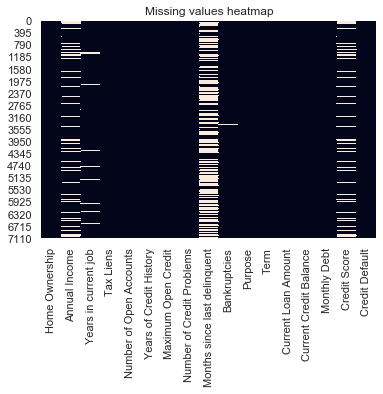

In [35]:
df_train.isnull().sum()
sns.heatmap(df_train.isnull(), cbar = False).set_title("Missing values heatmap")

In [36]:
df_train['Years in current job'].fillna(df_train['Years in current job'].mode()[0], inplace = True)
df_train['Bankruptcies'].fillna(df_train['Bankruptcies'].mode()[0], inplace = True)
df_train['Months since last delinquent'].fillna(df_train['Months since last delinquent'] == 'NA', inplace = True)
df_train['id'] = df_train.index.tolist()
df_train.drop('Credit Score', axis=1)
df_train.drop('Tax Liens', axis=1)

,Home Ownership,Annual Income,Years in current job,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,id
0,Own Home,482087.0,10+ years,11.0,26.3,685960.0,1.0,False,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0
1,Own Home,1025487.0,10+ years,15.0,15.3,1181730.0,0.0,False,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1
2,Home Mortgage,751412.0,8 years,11.0,35.0,1182434.0,0.0,False,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,2
3,Own Home,805068.0,6 years,8.0,22.5,147400.0,1.0,False,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,3
4,Rent,776264.0,8 years,13.0,13.6,385836.0,1.0,False,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,3.0,8.5,107866.0,0.0,False,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0,7495
7496,Home Mortgage,1533984.0,1 year,10.0,26.5,686312.0,0.0,43,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1,7496
7497,Rent,1878910.0,6 years,12.0,32.1,1778920.0,0.0,False,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0,7497
7498,Home Mortgage,NaN,10+ years,21.0,26.5,1141250.0,0.0,False,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0,7498


In [37]:
df_test_test['Years in current job'].fillna(df_test_test['Years in current job'].mode()[0], inplace = True)
df_test_test['Bankruptcies'].fillna(df_test_test['Bankruptcies'].mode()[0], inplace = True)
df_test_test['Months since last delinquent'].fillna(df_test_test['Months since last delinquent'] == 'NA', inplace = True)
df_test_test['id'] = df_test_test.index.tolist()
df_test_test.drop('Credit Score', axis=1)
df_test_test.drop('Tax Liens', axis=1)

,Home Ownership,Annual Income,Years in current job,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,id
0,Rent,NaN,4 years,9.0,12.5,220968.0,0.0,70,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN,0
1,Rent,231838.0,1 year,6.0,32.7,55946.0,0.0,8,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,1
2,Home Mortgage,1152540.0,3 years,10.0,13.7,204600.0,0.0,False,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0,2
3,Home Mortgage,1220313.0,10+ years,16.0,17.0,456302.0,0.0,70,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,3
4,Home Mortgage,2340952.0,6 years,11.0,23.6,1207272.0,0.0,False,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,14.0,29.1,559152.0,1.0,68,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0,2495
2496,Home Mortgage,NaN,2 years,15.0,17.0,1737780.0,0.0,77,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN,2496
2497,Home Mortgage,1171806.0,2 years,48.0,12.8,1706430.0,0.0,False,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0,2497
2498,Rent,723520.0,10+ years,14.0,28.8,945780.0,0.0,False,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0,2498


In [38]:
df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')
df_test = pd.read_csv(PREP_DATASET_PATH)

In [39]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_test.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

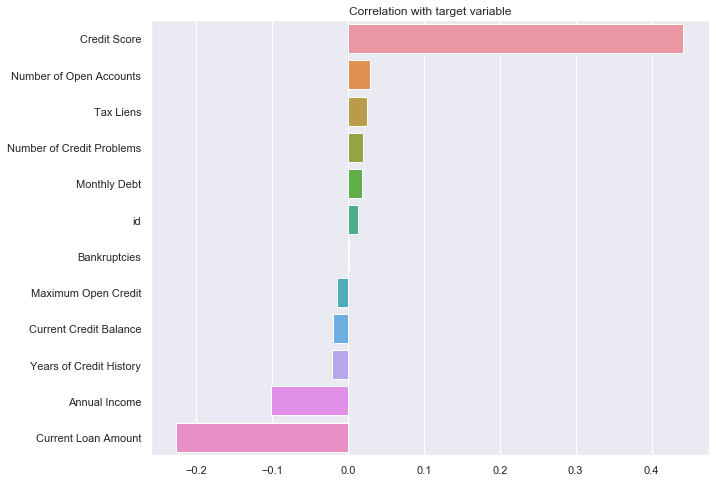

In [40]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

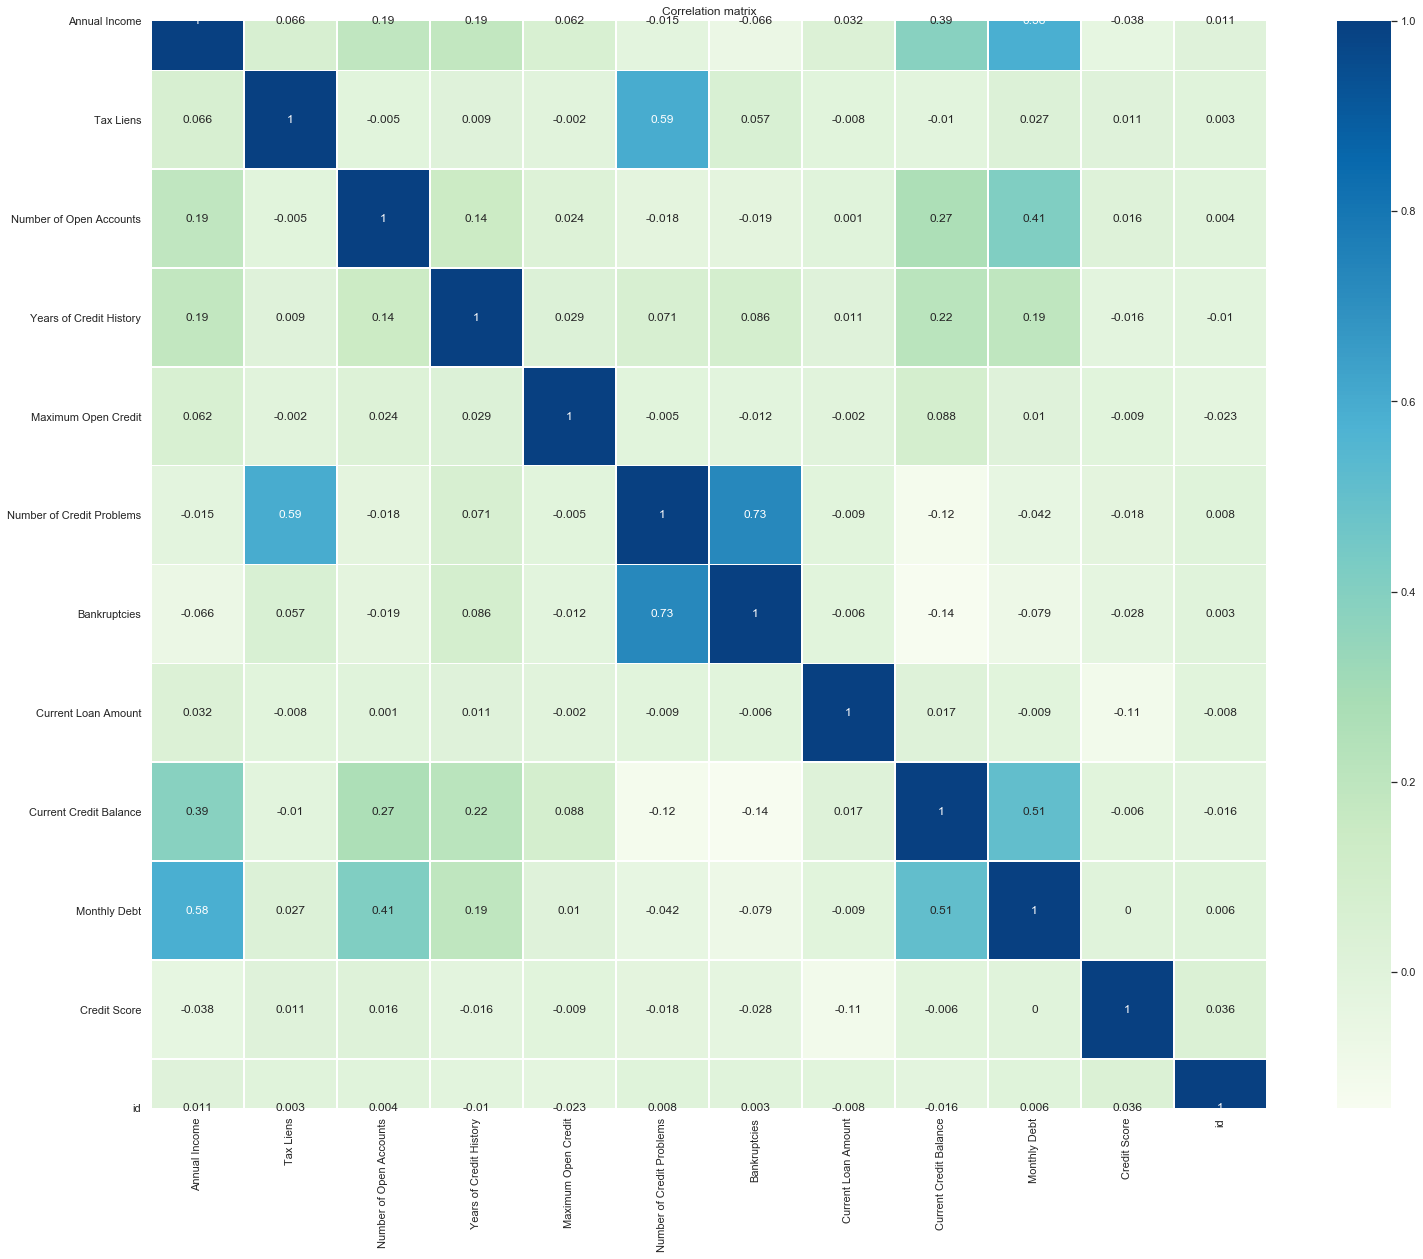

In [41]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.0)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [42]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [43]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [44]:
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME, 'id'] + BASE_FEATURE_NAMES).tolist()

In [45]:
for cat_colname in df_train.select_dtypes(include='object').columns[1:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

In [50]:
for cat_colname in df_test_test.select_dtypes(include='object').columns[1:]:
    df_test_test = pd.concat([df_test_test, pd.get_dummies(df_test_test[cat_colname], prefix=cat_colname)], axis=1)

In [51]:
df_train.info

<bound method DataFrame.info of      Home Ownership  Annual Income Years in current job  Tax Liens  \
0          Own Home       482087.0            10+ years        0.0   
1          Own Home      1025487.0            10+ years        0.0   
2     Home Mortgage       751412.0              8 years        0.0   
3          Own Home       805068.0              6 years        0.0   
4              Rent       776264.0              8 years        0.0   
...             ...            ...                  ...        ...   
7495           Rent       402192.0             < 1 year        0.0   
7496  Home Mortgage      1533984.0               1 year        0.0   
7497           Rent      1878910.0              6 years        0.0   
7498  Home Mortgage            NaN            10+ years        0.0   
7499           Rent            NaN              4 years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                        11.0                   

In [52]:
NUM_FEATURE_NAMES = ['Annual Income',
                     'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
                     'Number of Credit Problems', 'Credit Score',
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

CAT_FEATURE_NAMES = [
 'Home Ownership',
 'Bankruptcies',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_< 1 year',
 'Months since last delinquent_False',
 'Months since last delinquent_1.0',
 'Months since last delinquent_2.0',
 'Months since last delinquent_3.0',
 'Months since last delinquent_4.0',
 'Months since last delinquent_5.0',
 'Months since last delinquent_6.0',
 'Months since last delinquent_7.0',
 'Months since last delinquent_8.0',
 'Months since last delinquent_9.0',
 'Months since last delinquent_10.0',
 'Months since last delinquent_11.0',
 'Months since last delinquent_12.0',
 'Months since last delinquent_13.0',
 'Months since last delinquent_14.0',
 'Months since last delinquent_15.0',
 'Months since last delinquent_16.0',
 'Months since last delinquent_17.0',
 'Months since last delinquent_18.0',
 'Months since last delinquent_19.0',
 'Months since last delinquent_20.0',
 'Months since last delinquent_21.0',
 'Months since last delinquent_22.0',
 'Months since last delinquent_23.0',
 'Months since last delinquent_24.0',
 'Months since last delinquent_25.0',
 'Months since last delinquent_26.0',
 'Months since last delinquent_27.0',
 'Months since last delinquent_28.0',
 'Months since last delinquent_29.0',
 'Months since last delinquent_30.0',
 'Months since last delinquent_31.0',
 'Months since last delinquent_32.0',
 'Months since last delinquent_33.0',
 'Months since last delinquent_34.0',
 'Months since last delinquent_35.0',
 'Months since last delinquent_36.0',
 'Months since last delinquent_37.0',
 'Months since last delinquent_38.0',
 'Months since last delinquent_39.0',
 'Months since last delinquent_40.0',
 'Months since last delinquent_41.0',
 'Months since last delinquent_42.0',
 'Months since last delinquent_43.0',
 'Months since last delinquent_44.0',
 'Months since last delinquent_45.0',
 'Months since last delinquent_46.0',
 'Months since last delinquent_47.0',
 'Months since last delinquent_48.0',
 'Months since last delinquent_49.0',
 'Months since last delinquent_50.0',
 'Months since last delinquent_51.0',
 'Months since last delinquent_52.0',
 'Months since last delinquent_53.0',
 'Months since last delinquent_54.0',
 'Months since last delinquent_55.0',
 'Months since last delinquent_56.0',
 'Months since last delinquent_57.0',
 'Months since last delinquent_58.0',
 'Months since last delinquent_59.0',
 'Months since last delinquent_60.0',
 'Months since last delinquent_61.0',
 'Months since last delinquent_62.0',
 'Months since last delinquent_63.0',
 'Months since last delinquent_64.0',
 'Months since last delinquent_65.0',
 'Months since last delinquent_66.0',
 'Months since last delinquent_67.0',
 'Months since last delinquent_68.0',
 'Months since last delinquent_69.0',
 'Months since last delinquent_70.0',
 'Months since last delinquent_71.0',
 'Months since last delinquent_72.0',
 'Months since last delinquent_73.0',
 'Months since last delinquent_74.0',
 'Months since last delinquent_75.0',
 'Months since last delinquent_76.0',
 'Months since last delinquent_77.0',
 'Months since last delinquent_78.0',
 'Months since last delinquent_79.0',
 'Months since last delinquent_80.0',
 'Months since last delinquent_81.0',
 'Months since last delinquent_82.0',
 'Months since last delinquent_83.0',
 'Months since last delinquent_84.0',
 'Months since last delinquent_86.0',
 'Months since last delinquent_91.0',
 'Months since last delinquent_92.0',
 'Months since last delinquent_118.0',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding',
 'Term_Long Term',
 'Term_Short Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

In [53]:
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Home Ownership                    category
Bankruptcies                      category
Years in current job_1 year       category
Years in current job_10+ years    category
Years in current job_2 years      category
                                    ...   
Purpose_take a trip               category
Purpose_vacation                  category
Purpose_wedding                   category
Term_Long Term                    category
Term_Short Term                   category
Length: 119, dtype: object

In [57]:
df_test_test.columns
test_names = []
for name in df_test_test.columns:
    test_names.append(name)
test_names

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'id',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_< 1 year',
 'Months since last delinquent_False',
 'Months since last delinquent_1.0',
 'Months since last delinquent_2.0',
 'Months since last delinquent_3.0',
 'Months since last delinquent_4.0',
 'Months since last delinquent_5.0',
 'Months since last delinquent_6.0',
 'Months since last delin

In [60]:
NUM_FEATURE_NAMES_TEST = ['Annual Income',
                     'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
                     'Number of Credit Problems', 'Credit Score',
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

CAT_FEATURE_NAMES_TEST = [
 'Home Ownership',
 'Bankruptcies',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_< 1 year',
 'Months since last delinquent_False',
 'Months since last delinquent_1.0',
 'Months since last delinquent_2.0',
 'Months since last delinquent_3.0',
 'Months since last delinquent_4.0',
 'Months since last delinquent_5.0',
 'Months since last delinquent_6.0',
 'Months since last delinquent_7.0',
 'Months since last delinquent_8.0',
 'Months since last delinquent_9.0',
 'Months since last delinquent_10.0',
 'Months since last delinquent_11.0',
 'Months since last delinquent_12.0',
 'Months since last delinquent_13.0',
 'Months since last delinquent_14.0',
 'Months since last delinquent_15.0',
 'Months since last delinquent_16.0',
 'Months since last delinquent_17.0',
 'Months since last delinquent_18.0',
 'Months since last delinquent_19.0',
 'Months since last delinquent_20.0',
 'Months since last delinquent_21.0',
 'Months since last delinquent_22.0',
 'Months since last delinquent_23.0',
 'Months since last delinquent_24.0',
 'Months since last delinquent_25.0',
 'Months since last delinquent_26.0',
 'Months since last delinquent_27.0',
 'Months since last delinquent_28.0',
 'Months since last delinquent_29.0',
 'Months since last delinquent_30.0',
 'Months since last delinquent_31.0',
 'Months since last delinquent_32.0',
 'Months since last delinquent_33.0',
 'Months since last delinquent_34.0',
 'Months since last delinquent_35.0',
 'Months since last delinquent_36.0',
 'Months since last delinquent_37.0',
 'Months since last delinquent_38.0',
 'Months since last delinquent_39.0',
 'Months since last delinquent_40.0',
 'Months since last delinquent_41.0',
 'Months since last delinquent_42.0',
 'Months since last delinquent_43.0',
 'Months since last delinquent_44.0',
 'Months since last delinquent_45.0',
 'Months since last delinquent_46.0',
 'Months since last delinquent_47.0',
 'Months since last delinquent_48.0',
 'Months since last delinquent_49.0',
 'Months since last delinquent_50.0',
 'Months since last delinquent_51.0',
 'Months since last delinquent_52.0',
 'Months since last delinquent_53.0',
 'Months since last delinquent_54.0',
 'Months since last delinquent_55.0',
 'Months since last delinquent_56.0',
 'Months since last delinquent_57.0',
 'Months since last delinquent_58.0',
 'Months since last delinquent_59.0',
 'Months since last delinquent_60.0',
 'Months since last delinquent_61.0',
 'Months since last delinquent_62.0',
 'Months since last delinquent_63.0',
 'Months since last delinquent_64.0',
 'Months since last delinquent_65.0',
 'Months since last delinquent_66.0',
 'Months since last delinquent_67.0',
 'Months since last delinquent_68.0',
 'Months since last delinquent_69.0',
 'Months since last delinquent_70.0',
 'Months since last delinquent_71.0',
 'Months since last delinquent_72.0',
 'Months since last delinquent_73.0',
 'Months since last delinquent_74.0',
 'Months since last delinquent_75.0',
 'Months since last delinquent_76.0',
 'Months since last delinquent_77.0',
 'Months since last delinquent_78.0',
 'Months since last delinquent_79.0',
 'Months since last delinquent_80.0',
 'Months since last delinquent_81.0',
 'Months since last delinquent_82.0',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding',
 'Term_Long Term',
 'Term_Short Term']

SELECTED_FEATURE_NAMES_TEST = NUM_FEATURE_NAMES_TEST + CAT_FEATURE_NAMES_TEST

In [61]:
for colname in CAT_FEATURE_NAMES_TEST:
    df_test_test[colname] = pd.Categorical(df_test_test[colname])
    
df_test_test[CAT_FEATURE_NAMES_TEST].dtypes

Home Ownership                    category
Bankruptcies                      category
Years in current job_1 year       category
Years in current job_10+ years    category
Years in current job_2 years      category
                                    ...   
Purpose_take a trip               category
Purpose_vacation                  category
Purpose_wedding                   category
Term_Long Term                    category
Term_Short Term                   category
Length: 112, dtype: object

In [62]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_train = df_norm.copy()

In [63]:
df_norm_test = df_test.copy()
df_norm_test[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm_test[NUM_FEATURE_NAMES])

df_test = df_norm_test.copy()

In [64]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [65]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.15, random_state=42)

In [66]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    4592
1    3566
Name: Credit Default, dtype: int64

In [67]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [68]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [69]:
df_train.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

In [70]:
model_lgbm = lgbm.LGBMClassifier(num_leaves=6, max_depth=-1, learning_rate=0.25, 
                                 n_estimators=80, max_bin=125, random_state=42)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      4592
           1       0.79      0.63      0.70      3566

    accuracy                           0.77      8158
   macro avg       0.77      0.75      0.76      8158
weighted avg       0.77      0.77      0.76      8158

TEST

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       795
           1       0.56      0.53      0.54       330

    accuracy                           0.74      1125
   macro avg       0.68      0.68      0.68      1125
weighted avg       0.74      0.74      0.74      1125

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               655  140
1               154  176


In [74]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

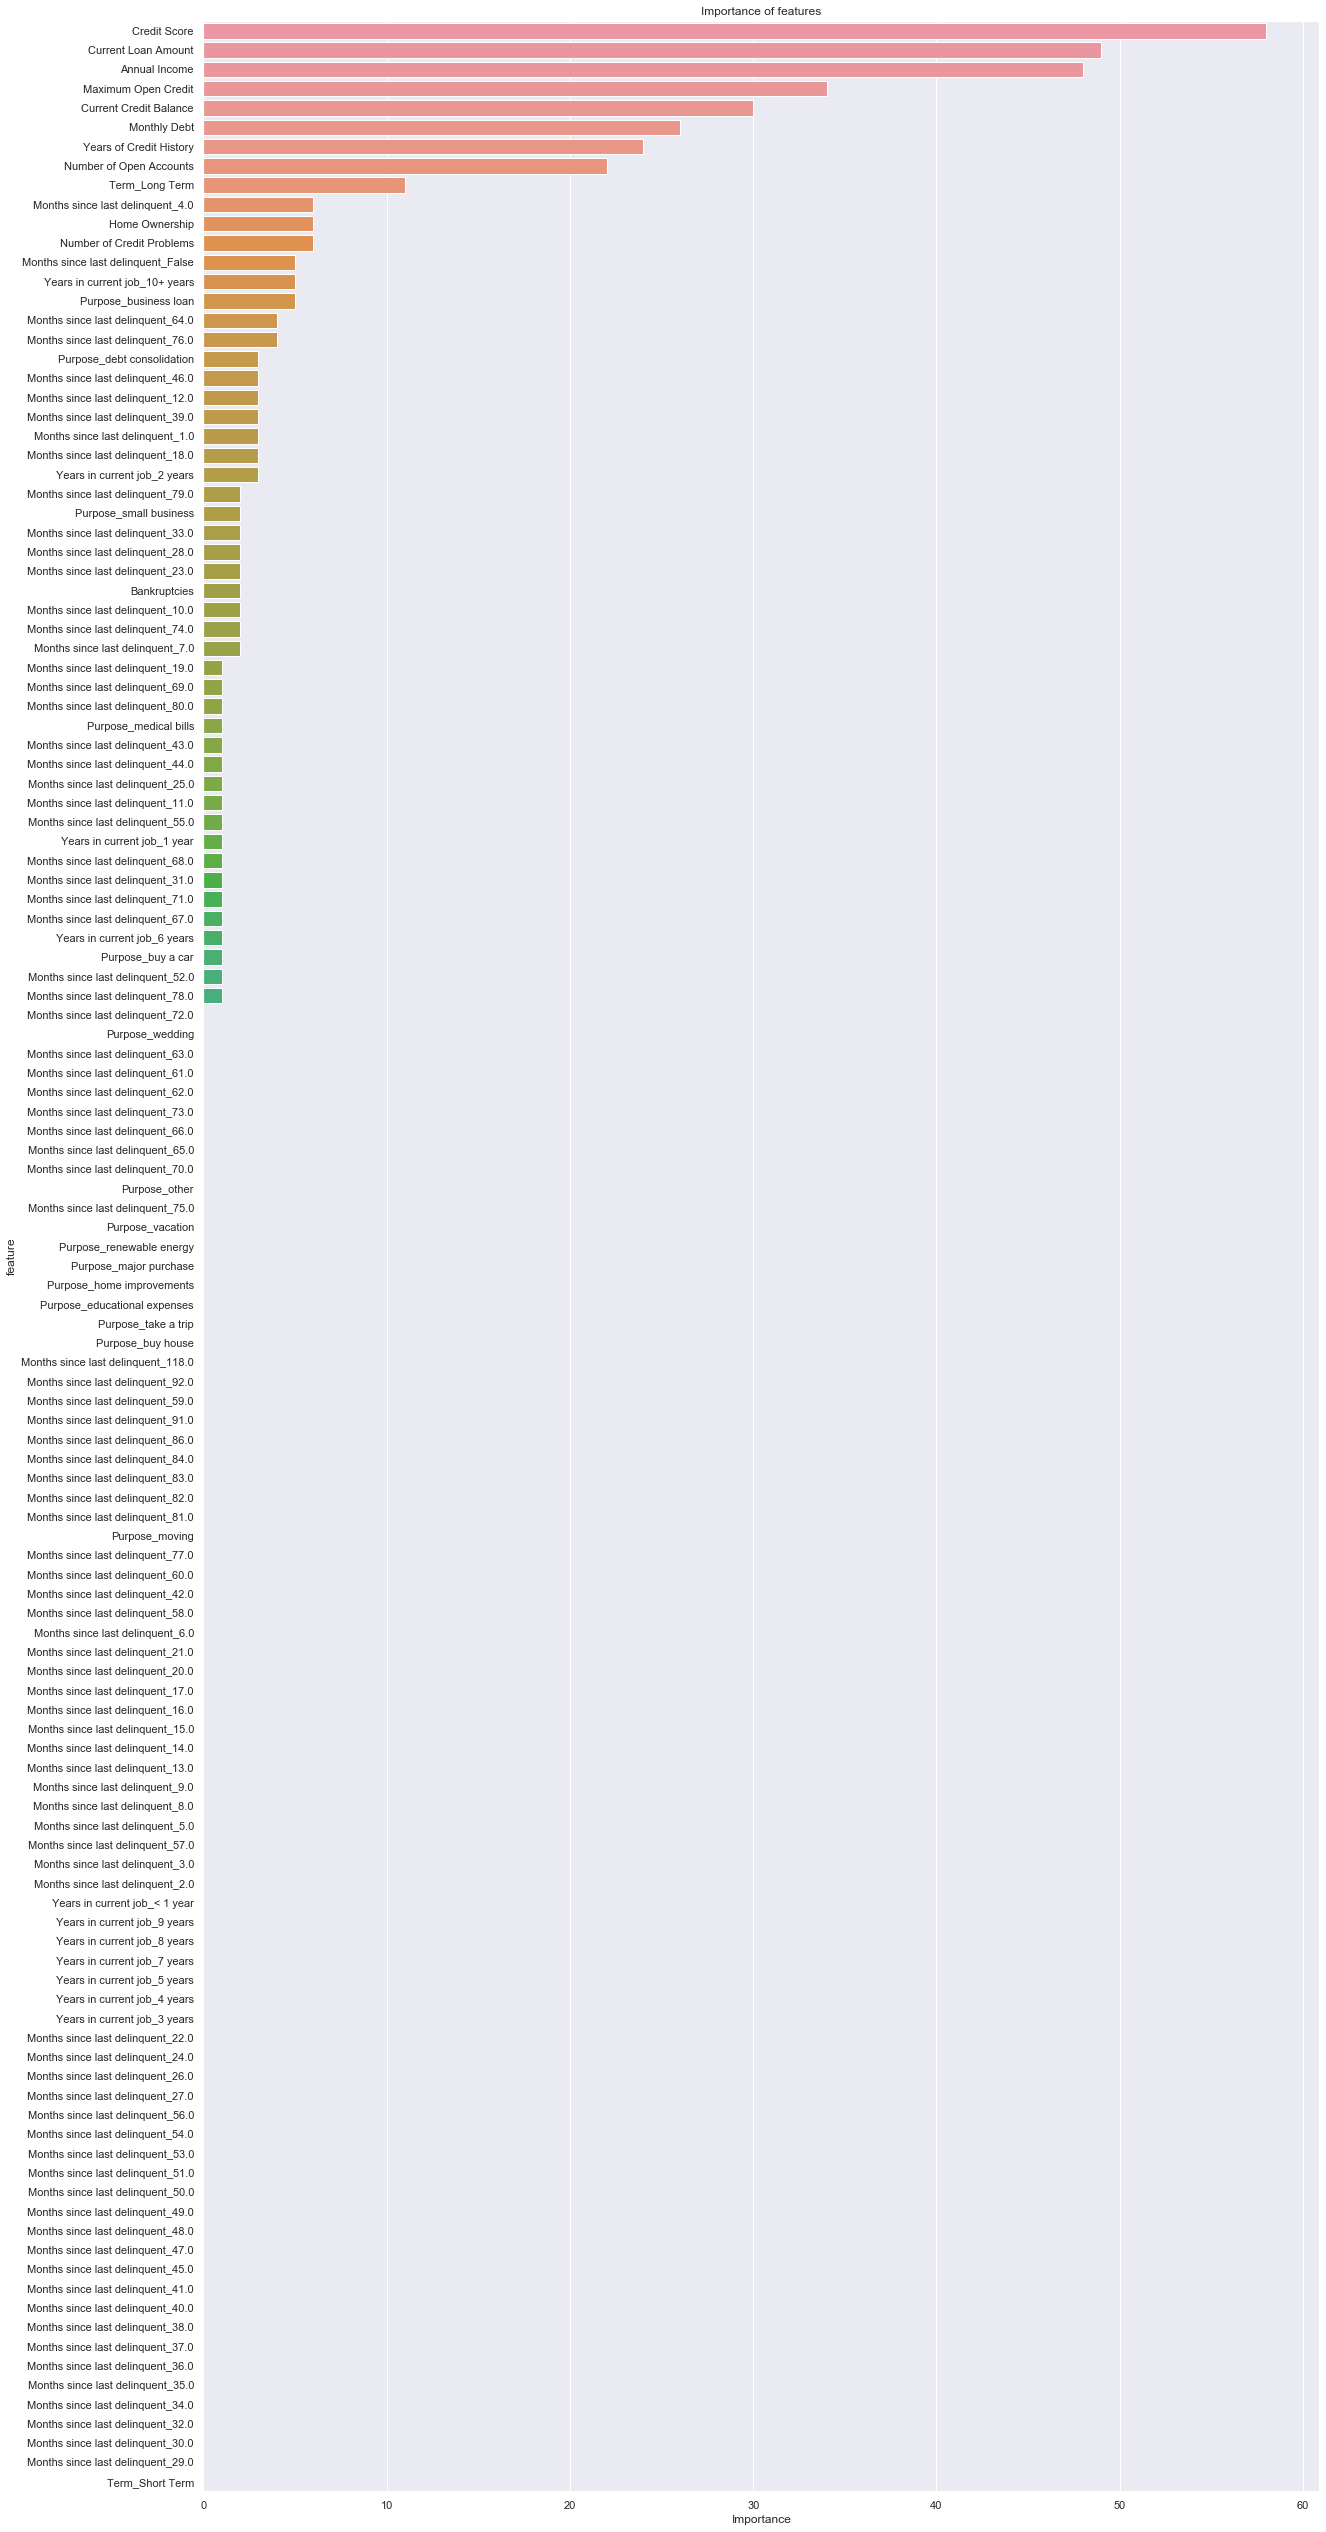

In [76]:
important_features_top = show_feature_importances(X_train.columns, model_lgbm.feature_importances_, get_top=15)

In [79]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Annual Income',
 'Maximum Open Credit',
 'Current Credit Balance',
 'Monthly Debt',
 'Years of Credit History',
 'Number of Open Accounts',
 'Term_Long Term',
 'Months since last delinquent_4.0',
 'Home Ownership',
 'Number of Credit Problems',
 'Months since last delinquent_False',
 'Years in current job_10+ years',
 'Purpose_business loan']

In [82]:
model_lgbm.fit(X_train[important_features_top], y_train)
y_train_pred = model_lgbm.predict(X_train[important_features_top])
y_test_pred = model_lgbm.predict(X_test[important_features_top])
y_test_pred_probs = model_lgbm.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      4592
           1       0.80      0.64      0.71      3566

    accuracy                           0.77      8158
   macro avg       0.78      0.76      0.76      8158
weighted avg       0.78      0.77      0.77      8158

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       795
           1       0.56      0.52      0.54       330

    accuracy                           0.74      1125
   macro avg       0.68      0.67      0.68      1125
weighted avg       0.73      0.74      0.74      1125

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               660  135
1               159  171


In [97]:
y_test_test_predict = model_lgbm.predict(df_test_test[important_features_top])

y_test_test_pred = pd.DataFrame()
y_test_test_pred['Id'] = df_test_test.index
y_test_test_pred['Credit Default'] = y_test_test_predict

y_test_test_pred.head()

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [99]:
y_test_test_pred.to_csv('OKodryanu_predict.csv', encoding='utf-8')